In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import RectangleSelector
#from tabulate import tabulate
from sklearn.cluster import DBSCAN
import tkinter.filedialog as tkf
from scipy import optimize
import ipywidgets as pyw

In [81]:
# refer to https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)
#장축이 x,y 축이 아닐 때를 표현하지 못함.

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y



def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [82]:
def gaussian_center(image, cbox_edge=0):
    y, x = np.indices(image.shape)
    if not cbox_edge:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    else:
        cbox_outy = int(image.shape[0]/2 - cbox_edge/2)
        cbox_outx = int(image.shape[1]/2 - cbox_edge/2)
        center_box = image[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
        fit_params = fitgaussian(center_box)
        (_, center_y, center_x, _, _) = fit_params
        center = [center_y+cbox_outy, center_x+cbox_outx]
        
    return center

In [83]:
def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [84]:
# refer to github.com/mkolopanis/python/blob/master/radialProfile.py

def radial_variance(image, profile_resolution=1.0, center=None):
   
    y, x = np.indices(image.shape) * profile_resolution
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0]*profile_resolution, x - center[1]*profile_resolution)
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    csim = np.cumsum(i_sorted, dtype=float)
    sq_csim = np.cumsum(np.square(i_sorted), dtype=float)
    
    #plt.plot(np.square(csim), c="red")
    #plt.plot(sq_csim, c="blue")
    
    avg_square = np.square((csim[rind[1:]] - csim[rind[:-1]]) / nr)
    square_avg = (sq_csim[rind[1:]] - sq_csim[rind[:-1]]) / nr
    
    #plt.plot(avg_square[20:], c="red")
    #plt.plot(square_avg[20:], c="blue")
    
    mask = avg_square.copy()
    mask[np.where(avg_square==0)] = 1.0
    radial_var = (square_avg - avg_square) / mask
    
    return radial_var    

In [85]:
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    raw_stack = np.fromfile(img_adr, dtype=datatype)
    stack = raw_stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

In [86]:
#raw_adr = tkf.askopenfilename()
raw_adr = "E:/4DSTEM_Tomography/DGIST 20190925/REF_40nm_03/scan_x256_y256.raw"
print(raw_adr)

E:/4DSTEM_Tomography/DGIST 20190925/REF_40nm_03/scan_x256_y256.raw


In [87]:
datatype = "float32"
o_shape = (256, 256, 130, 128)
f_shape = (256, 256, 128, 128)

In [88]:
# load a data
stack_4d = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))
#print(np.median(stack_4d))

(256, 256, 130, 128)
(256, 256, 128, 128)
2487695.0
1206.0
11237.69


In [89]:
%matplotlib qt

In [90]:
# select an interesting area
#%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.sum(stack_4d, axis=(2, 3)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (130.796542, 106.684695)
endposition  : (160.465416, 135.882634)


In [91]:
# crop the data
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
print(stack_4d_cropped.shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

(29, 30, 128, 128)
1174495.0
1418.0
9408.237


In [92]:
%matplotlib inline

(29, 30, 2)
[64.26413837 63.99368775]


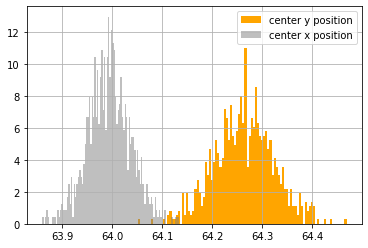

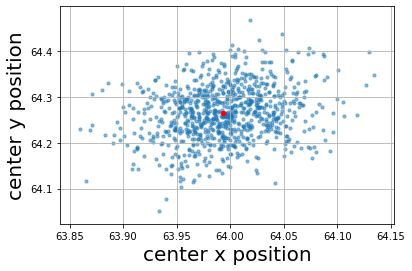

In [93]:
# find center position
center_pos = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        center_pos.append(gaussian_center(stack_4d_cropped[i, j], cbox_edge=30))
        
center_pos = np.asarray(center_pos)
center_pos = np.reshape(center_pos, (stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1))
print(center_pos.shape)
center_mean = np.mean(center_pos, axis=(0, 1))
print(center_mean)

# center distibution
plt.figure()
plt.hist(center_pos[:, :, 0].flatten(), bins=100, density=True, color="orange", label="center y position")
plt.hist(center_pos[:, :, 1].flatten(), bins=100, density=True, color="gray", alpha=0.5, label="center x position")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(center_pos[:, :, 1], center_pos[:, :, 0], s=10.0, alpha=0.5)
plt.grid()
plt.scatter(center_mean[1], center_mean[0], s=20, c="red")
plt.xlabel("center x position", fontsize=20)
plt.ylabel("center y position", fontsize=20)
plt.show()

In [94]:
# remove center beam
stack_4d_cropped_cb = stack_4d_cropped.copy()
center_radius = 20
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

48819.0
0.0
4915.0337


In [95]:
def remove_unimportant(image, inner_r, outer_r, center=None):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0]) 
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<inner_r)
    image[ri] = 0
    ri = np.where(r>outer_r)
    image[ri] = 0
    return image

stack_4d_peakrange = stack_4d_cropped.copy()
inner_radius = 21
outer_radius = 33
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        temp = remove_unimportant(stack_4d_peakrange[i, j], inner_radius, outer_radius, center=center_mean.tolist())
        normalization_coeff = np.sum(temp*temp)**0.5
        stack_4d_peakrange[i, j] = temp/normalization_coeff
        

(29, 30, 90)
(90,)


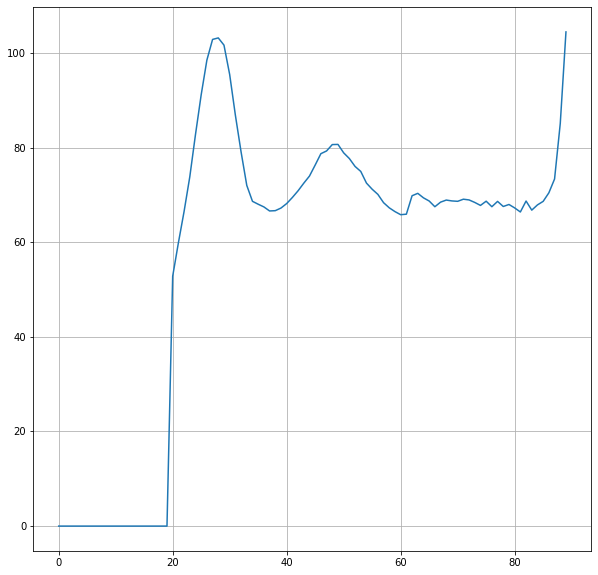

In [96]:
# calculate variance with all angles at a certain k
radial_var_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_variance(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_var_stack.append(radial_temp)

if len(np.unique(len_profile)) > 1:
    print(np.unique(len_profile))
    shortest = np.min(len_profile)
    for i in range(len(len_profile)):
        radial_var_stack[i] = radial_var_stack[i][:shortest]

radial_var_stack = np.asarray(radial_var_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_var_stack.shape)

radial_var_sum = np.sum(radial_var_stack, axis=(0, 1))
print(radial_var_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_var_sum)
plt.grid()
plt.show()

In [97]:
%matplotlib inline

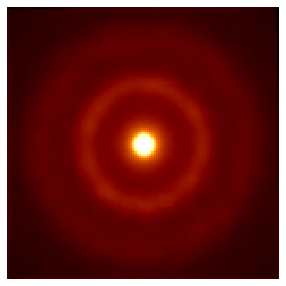

In [98]:
radii = np.arange(len(radial_var_sum))
#pacbed = np.mean(stack_4d_cropped, axis=(0, 1))
pacbed = np.log(np.mean(stack_4d_cropped_cb, axis=(0, 1)))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(pacbed, cmap="afmhot")
ax.axis("off")
plt.show()

In [99]:
k1 = 27
k2 = 29
p1 = 90.0
p2 = 99.9
v1 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p1)
v2 = np.percentile(radial_var_stack[:, :, k1:(k2+1)], p2)

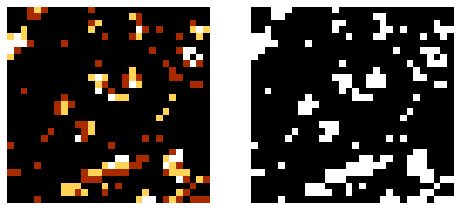

In [100]:
masked = radial_var_stack[:, :, k1:(k2+1)].copy()
img_tmp = np.ones_like(masked)
img_tmp[np.where(masked < v1)] = 0
img_tmp[np.where(masked > v2)] = 0
img = np.sum(img_tmp, axis=2)
bool_img = np.zeros_like(img)
bool_img[np.where(img != 0)] = 1

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img, cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(bool_img, cmap="afmhot")
ax[1].axis("off")
plt.show()

number of clusters = 13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


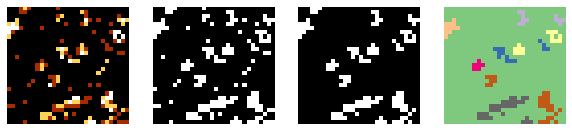

In [101]:

min_num = 4
epsilon = 2**(1/2)
db = DBSCAN(eps=epsilon, min_samples=min_num)
sel_coor = np.nonzero(bool_img)
X = np.stack((sel_coor[0], sel_coor[1]), axis=1)
db.fit(X)
img_tmp = np.zeros_like(bool_img)
img_tmp += -1
img_tmp[X[:, 0], X[:, 1]] = db.labels_
labeled_cluster_img = img_tmp.copy()
cluster_img = np.where(img_tmp<0, img_tmp, 1)
cluster_img = np.where(cluster_img>-1, bool_img, 0)  #왜 두 줄에 걸쳐 한것?

label = np.unique(db.labels_)[1:]
print("number of clusters = %d"%(len(label)))
print(label)

fig, ax = plt.subplots(1, 4, figsize=(10, 4))
ax[0].imshow(img, cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(bool_img, cmap="afmhot")
ax[1].axis("off")
ax[2].imshow(cluster_img, cmap="afmhot")
ax[2].axis("off")
ax[3].imshow(labeled_cluster_img, cmap="Accent")
ax[3].axis("off")
plt.show()


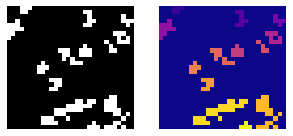

In [102]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(cluster_img, cmap="afmhot")
ax[0].axis("off")
ax[1].imshow(labeled_cluster_img, cmap="plasma")
ax[1].axis("off")
plt.show()

In [203]:
%matplotlib qt
fig, ax = plt.subplots(2,2, figsize=(12, 12))

im00 = ax[0,0].imshow(cluster_img, cmap="afmhot")
ax[0,0].set_title("Selected label image")
im01 = ax[0,1].imshow(img, cmap="afmhot")
ax[0,1].set_title("Image")
im10 = ax[1,0].imshow(stack_4d_cropped[0,0,:,:], cmap="afmhot")
ax[1,0].set_title("DP of ")
im11 = ax[1,1].plot([1,2])
ax[1,1].set_title("Press shift or alt key and click image")

    
summing_radius = 0
click_px = 0
click_py = 0
selected_pixel = np.empty((1,2),'int')

def onclick(event):
    #collect event data
    ( px, py ) =  event.xdata.astype(int), event.ydata.astype(int)
    ptcl_label = labeled_cluster_img[py,px]  # xy squence ?
    #print("particle label : %d"%ptcl_label) 
    #collect global data
    global click_px, click_py, summing_radius, selected_pixel
    print(event.key)

    
    if event.key == 'control': # with pressing ctrl key --> add or delete selected pixel
        exist = -1
        for i in range(len(selected_pixel)):
            if selected_pixel[i,0]==px and selected_pixel[i,1]==py:
                exist=i
        if exist!=-1: selected_pixel = np.delete(selected_pixel,[exist,exist],axis=0)
        else:         selected_pixel = np.append(selected_pixel,[[px,py]],axis=0)

            
    else:   # selecting pixel with mouse click
        selected_pixel = np.asarray([[px,py]],"int")
        if event.dblclick ==1 and ptcl_label>-1:
            selected_pixel = X[np.where(db.labels_==ptcl_label)][:,[1,0]]  
        elif click_px == px and click_py == py :
            summing_radius +=1
            #print("%dth same point"% summing_radius)
            selected_pixel = np.stack(np.meshgrid(range(-summing_radius,summing_radius+1),range(-summing_radius,summing_radius+1)),
                                  axis=2).reshape((2*summing_radius+1)**2,2) + [px,py]   
        else: summing_radius = 0 
    click_px = px
    click_py = py
    
        
    #유사도 측정 keydown "SHIFT"   
    if event.key =='shift':
        print(event.key)
        summed_pDP = np.zeros((128,128))
        for x, y in selected_pixel:  
            summed_pDP += stack_4d_peakrange[y,x,:,:]
        avg_pDP = summed_pDP/len(selected_pixel)
        
        similarity = cluster_img.copy()
        for x, y in selected_pixel:  
            similarity[y,x] = (np.sum(stack_4d_peakrange[py,px,:,:]*stack_4d_peakrange[y,x,:,:])-0.89)*100
            print(similarity[py,px])
        im10 = ax[1,1].imshow(similarity, cmap="afmhot")
    
    #픽셀별 그래프 그리기
    if event.key == 'alt':
        print(event.key)
        a=(29)*np.exp(np.linspace(0, np.pi*2, 500)*1j)+center_mean[0]+center_mean[1]*1j
        b = np.real(a).astype(int)
        bw= 1-(np.real(a)-b)
        c = np.imag(a).astype(int)
        cw= 1-(np.imag(a)-c)
        count = 0
        length = len(selected_pixel)
        
        ax[1,1].cla()
        for x,y in selected_pixel:
            count+=1
            img1 = stack_4d_cropped[y,x,:,:]
            theta_expand = np.zeros(500)
            theta_expand = img1[b,c]*bw*cw + img1[b+1,c]*(1-bw)*cw + img1[b,c+1]*bw*(1-cw) + img1[b+1,c+1]*(1-bw)*(1-cw)
            ax[1,1].plot(theta_expand, c=plt.cm.rainbow(count/length), label = '%s'%count)
    
        ax[1,1].set_title("Intensity(theta) plot with varing pixel")
        ax[1,1].legend(fontsize='xx-small')
        ax[1,1].size()
        
    
    #imaging
    ax[0,0].cla()
    ax[0,1].cla()
    selected_cluster_img = cluster_img.copy()
    selected_img         = img.copy()
    for px, py in selected_pixel:  
        selected_cluster_img[py,px] = 0.65 if selected_cluster_img[py,px] == 1 else 0.4
        selected_img[py,px]         = 5
    im00 = ax[0,0].imshow(selected_cluster_img, cmap="afmhot")
    ax[0,0].set_title("Selected cluster image")
    im01 = ax[0,1].imshow(selected_img, cmap="afmhot")
    ax[0,1].set_title("Selected image")
    
    ax[1,0].cla()
    summed_DP = np.zeros((128,128))
    for px, py in selected_pixel:  
        summed_DP += stack_4d_cropped[py,px,:,:]
    im10 = ax[1,0].imshow(summed_DP, cmap="afmhot")
    ax[1,0].set_title("DP at %d, %d"%(px,py))
    fig.canvas.draw() 
    
    return



cid = fig.canvas.mpl_connect('button_press_event', onclick)



None
None
alt
alt
alt
alt


Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'


alt
alt


Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'


alt
alt
alt
alt


Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'


alt
alt


Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'


None
alt
alt
alt
alt


Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 87, in onclick
    ax[1,1].size()
AttributeError: 'AxesSubplot' object has no attribute 'size'
Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\ML\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-203-924730d67c14>", line 21, in onclick
    ( px, py ) =  event.xdata.astype(int), event.ydata.astype(int)
AttributeError: 'NoneType' object has no attribute 'astype'


In [115]:

img1 = stack_4d_peakrange[20,20,:,:]
img2 = stack_4d_peakrange[20,21,:,:]
plt.imshow(img2,cmap='afmhot')

In [196]:


img4 = np.zeros((128,128))

for i in range(20):

    a=(40+i)*np.exp(np.linspace(0, np.pi*2,100000)*1j)+center_mean[0]+center_mean[1]*1j
    b = np.real(a).astype(int)
    bw= 1-(np.real(a)-b)
    c = np.imag(a).astype(int)
    cw= 1-(np.imag(a)-c)
    img4[b,c]     += bw*cw
    img4[b+1,c]   += (1-bw)*cw
    img4[b,c+1]   += bw*(1-cw)
    img4[b+1,c+1] += (1-bw)*(1-cw)
plt.imshow(img4,cmap='afmhot')


In [198]:
# I(theta) with k variation
%matplotlib qt
fig, ax = plt.subplots(2,1, figsize=(18, 12))

img1 = stack_4d_cropped[15,20,:,:]

for i in range(23,34):
    a=(i)*np.exp(np.linspace(0, np.pi*2,500)*1j)+center_mean[0]+center_mean[1]*1j
    b = np.real(a).astype(int)
    bw= 1-(np.real(a)-b)
    c = np.imag(a).astype(int)
    cw= 1-(np.imag(a)-c)

    theta_expand = np.zeros(500)
    theta_expand = img1[b,c]*bw*cw + img1[b+1,c]*(1-bw)*cw + img1[b,c+1]*bw*(1-cw) + img1[b+1,c+1]*(1-bw)*(1-cw)
    ax[1].plot(theta_expand, c=plt.cm.rainbow(0.1*(i-23)), label = '%s'%i)
             



im0 = ax[0].imshow(img1, cmap="afmhot")
ax[0].set_title("DP")
ax[1].set_title("Image")
ax[1].legend(fontsize='xx-small')
fig.show()


In [197]:
# I(theta) with position variation



%matplotlib qt
fig, ax = plt.subplots(2,1, figsize=(18, 12))

img1 = stack_4d_cropped[15,20,:,:]


a=(29)*np.exp(np.linspace(0, np.pi*2, 500)*1j)+center_mean[0]+center_mean[1]*1j
b = np.real(a).astype(int)
bw= 1-(np.real(a)-b)
c = np.imag(a).astype(int)
cw= 1-(np.imag(a)-c)
count = 0
length = len(selected_pixel)

for x,y in selected_pixel:
    count+=1
    img1 = stack_4d_cropped[y,x,:,:]
    theta_expand = np.zeros(500)
    theta_expand = img1[b,c]*bw*cw + img1[b+1,c]*(1-bw)*cw + img1[b,c+1]*bw*(1-cw) + img1[b+1,c+1]*(1-bw)*(1-cw)
    ax[1].plot(theta_expand, c=plt.cm.rainbow(count/length), label = '%s'%count)
             

im0 = ax[0].imshow(img1, cmap="afmhot")
ax[0].set_title("DP")
ax[1].set_title("Image")
ax[1].legend(fontsize='xx-small')
fig.show()


In [189]:
plt.plot

7